In [737]:
import pandas as pd                     
import csv                              
import numpy as np                     
import matplotlib.pyplot as plt         
import tensorflow as tf               
from tensorflow import keras

data = pd.read_csv('plik_z_koordynatami_sf.csv')

In [738]:
data.head()

,Product,Sales,Weekday,Month,Latitude,Longitude
0,27in FHD Monitor,149.99,7,12,37.644586,-122.422182
1,USB-C Charging Cable,23.90,5,12,37.656598,-122.423914
2,Wired Headphones,11.99,1,12,37.778087,-122.395774
3,AAA Batteries (4-pack),11.96,3,12,37.691105,-122.417659
4,Wired Headphones,11.99,3,12,37.738215,-122.424128


In [739]:
data['Product'].nunique()

19

Widać że kolumna 'Product' ma tylko 19 różnych produktów, co pozwoli na zastosowanie one-hot-encoding do ich reprezentacji.

In [741]:
def print_unique(column):
    print("ilość powtórzeń unikatowych wartości w kolumnie")
    value_counts = data[column].value_counts()
    print(value_counts)
    print('')

In [742]:
data.head()

,Product,Sales,Weekday,Month,Latitude,Longitude
0,27in FHD Monitor,149.99,7,12,37.644586,-122.422182
1,USB-C Charging Cable,23.90,5,12,37.656598,-122.423914
2,Wired Headphones,11.99,1,12,37.778087,-122.395774
3,AAA Batteries (4-pack),11.96,3,12,37.691105,-122.417659
4,Wired Headphones,11.99,3,12,37.738215,-122.424128


Teraz zrobię one hot encoding.

In [744]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# zamiana produktów na one hot encoding

products = np.array(data['Product'])

label_encoder = LabelEncoder()
product_labels = label_encoder.fit_transform(products)
one_hot_products = to_categorical(product_labels)
print(one_hot_products[:1])

# one hot encoding dla miesięcy i dni

months = np.array(data['Month'])
month_labels = label_encoder.fit_transform(months)
one_hot_months = to_categorical(month_labels)
print(one_hot_months[:1])

week_day = np.array(data['Weekday'])
week_day_labels = label_encoder.fit_transform(week_day)
one_hot_week_day = to_categorical(week_day_labels)
print(one_hot_week_day[:1])

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 1.]]


Następnie zrobię normalizację danych wysokości i szerokości geograficznej oraz popytu.

In [746]:
data.describe()

,Sales,Weekday,Month,Latitude,Longitude
count,44732.00000,44732.000000,44732.000000,44732.000000,44732.000000
mean,184.70455,3.999061,7.053563,37.701925,-122.450085
std,332.56451,1.996476,3.507761,0.055339,0.035976
min,2.99000,1.000000,1.000000,37.606754,-122.512834
25%,11.95000,2.000000,4.000000,37.653895,-122.481211
50%,14.95000,4.000000,7.000000,37.701682,-122.450096
75%,150.00000,6.000000,10.000000,37.750299,-122.418995
max,3400.00000,7.000000,12.000000,37.797281,-122.387574


In [747]:
# Normalizacja kolumn 'Longitude' i 'Latitude' bez pętli
data['Longitude'] = 10*(data['Longitude'] - data['Longitude'].min()) / (data['Longitude'].max() - data['Longitude'].min()) + 5
data['Latitude'] = 10*(data['Latitude'] - data['Latitude'].min()) / (data['Latitude'].max() - data['Latitude'].min()) + 5


In [748]:
print(data['Longitude'][0])

12.237148889403876


In [749]:
longitude = np.array(data['Longitude'])
latitude = np.array(data['Latitude'])
sales = np.array(data['Sales'])

In [750]:
data.describe()
print(data['Longitude'][0])

12.237148889403876


In [751]:
data.head()

,Product,Sales,Weekday,Month,Latitude,Longitude
0,27in FHD Monitor,149.99,7,12,6.985639,12.237149
1,USB-C Charging Cable,23.90,5,12,7.616118,12.098858
2,Wired Headphones,11.99,1,12,13.992541,14.345384
3,AAA Batteries (4-pack),11.96,3,12,9.427226,12.598194
4,Wired Headphones,11.99,3,12,11.899866,12.081786


Teraz połączę te dane w jeden wielki tensor inputowy

In [753]:
longitude = longitude.reshape(-1, 1)
latitude = latitude.reshape(-1, 1)

print(data['Longitude'][0])

12.237148889403876


In [754]:
input_data = np.concatenate([
    one_hot_products,   # (185950, 19)
    one_hot_months,     # (185950, 12)
#    one_hot_day,        # (185950, 31)
    one_hot_week_day,   # (185950, 7)
    longitude,          # (185950, 1)
    latitude,           # (185950, 1)
], axis=1)

print(input_data.shape)

output_data = sales
print(output_data.shape)

print(input_data[100])

(44732, 40)
(44732,)
[0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         1.         0.         0.         0.
 0.         0.         8.03497129 7.97728497]


Tworzę model który na wejście

In [756]:
print(one_hot_products.shape[1])
print(one_hot_months.shape[1])
print((one_hot_products.shape[1],))

19
12
(19,)


from sklearn.model_selection import train_test_split
from sklearn import metrics

one_hot_products_train, one_hot_products_val, one_hot_months_train, one_hot_months_val, one_hot_day_train, one_hot_day_val, one_hot_week_day_train, one_hot_week_day_val, longitude_train, longitude_val, latitude_train, latitude_val, sales_train, sales_val = train_test_split(one_hot_products, one_hot_months, one_hot_day, one_hot_week_day, longitude, latitude, sales, 
												test_size = 0.3,
												random_state = 66)

print(one_hot_products_train.shape, ' ', one_hot_products_val.shape, ' ', one_hot_products.shape)
print(sales_train.shape, ' ', sales_val.shape)
print(one_hot_products_train[:1])
print(longitude_train[:1])

In [758]:
print(input_data[0])
print(output_data[0])
input_data = np.array(input_data)

[ 0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          1.         12.23714889  6.98563939]
149.99


In [759]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

input_data_train, input_data_val, output_data_train, output_data_val = train_test_split(input_data, output_data, 
												test_size = 0.2,
												random_state = 33)

print(output_data_train.shape, ' ', output_data_val.shape, ' ', output_data.shape)

(35785,)   (8947,)   (44732,)


In [760]:
print(input_data_train[0])
print(output_data_train[0])

[0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         8.57423342 5.79712115]
8.97


input_product = Input(shape=(one_hot_products_train.shape[1],), name='input_product')
input_month = Input(shape=(one_hot_months_train.shape[1],), name='input_month')
input_day = Input(shape=(one_hot_day_train.shape[1],), name='input_day')
input_weekday = Input(shape=(one_hot_week_day_train.shape[1],), name='input_weekday')
input_longitude = Input(shape=(1,), name='input_longitude')
input_latitude = Input(shape=(1,), name='input_latitude')

x1 = Dense(5, activation='relu')(input_product)
x2 = Dense(5, activation='relu')(input_month)
x3 = Dense(5, activation='relu')(input_day)
x4 = Dense(5, activation='relu')(input_weekday)
x5 = Dense(5, activation='relu')(input_longitude)
x6 = Dense(5, activation='relu')(input_latitude)

concatenated = concatenate([x1, x2, x3, x4, x5, x6])

layer1 = Dense(64, activation='relu')(concatenated)

outputs = Dense(1, activation='linear')(layer1)  # 'linear', ponieważ chcemy przewidzieć wartość ciągłą (sprzedaż)

model = Model(inputs=[input_product, input_month, input_day, input_weekday, input_longitude, input_latitude], outputs=outputs)

# Podsumowanie modelu
model.summary()

In [762]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(input_data.shape[1],), name='inputs')

x1 = Dense(20, activation='relu')(inputs)

layer1 = Dense(64, activation='relu')(x1)

layer2 = Dense(32, activation='relu')(layer1)

outputs = Dense(1, activation='linear')(layer2) 

# Tworzenie modelu
model = Model(inputs=inputs, outputs=outputs)

# Podsumowanie modelu
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,277 (16.71 KB)

 Trainable params: 4,277 (16.71 KB)

 Non-trainable params: 0 (0.00 B)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(x=[one_hot_products_train, one_hot_months_train, one_hot_day_train, one_hot_week_day_train, longitude_train, latitude_train], y=sales_train, 
    validation_data=(
        [one_hot_products_val, one_hot_months_val, one_hot_day_val, one_hot_week_day_val, longitude_val, latitude_val], 
        sales_val
    ),
    epochs=10, 
    batch_size=32
)

from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)

In [765]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(input_data_train, output_data_train,
    validation_data=(
        input_data_val, 
        output_data_val
    ),
    epochs=3, 
    batch_size=64
)

Epoch 1/3
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - loss: 116496.9297 - mae: 190.8249 - val_loss: 47508.9531 - val_mae: 98.9462
Epoch 2/3
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 24417.0781 - mae: 70.4734 - val_loss: 980.6180 - val_mae: 17.9064
Epoch 3/3
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 482.8401 - mae: 12.3214 - val_loss: 257.5263 - val_mae: 8.5061


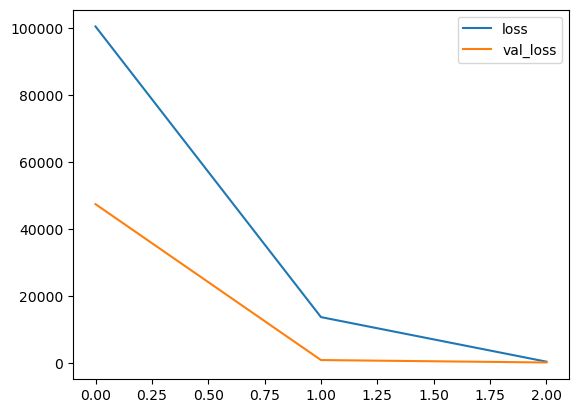

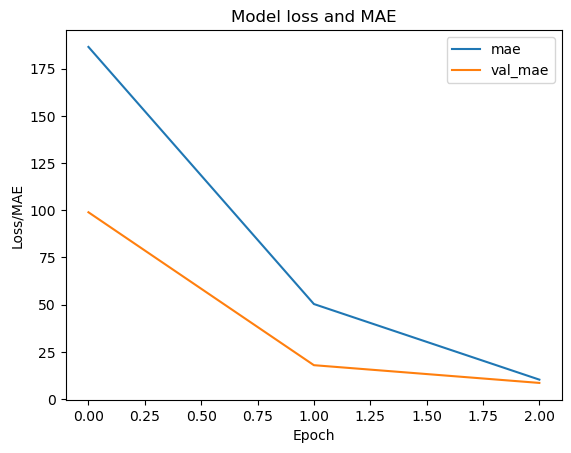

In [766]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['mae', 'val_mae']].plot()
plt.title('Model loss and MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss/MAE')
plt.show()

Przewidywanie wartości

In [768]:
data_for_prediction = pd.read_csv('data for prediction.csv')

In [769]:
def preparing_input(data, index):
    label_encoder = LabelEncoder()

    products = np.array(data['Product'])
    product_labels = label_encoder.fit_transform(products)
    one_hot_products = to_categorical(product_labels)
    
    months = np.array(data['Month'])
    month_labels = label_encoder.fit_transform(months)
    one_hot_months = to_categorical(month_labels)
    print(one_hot_months[:1])
    
    week_day = np.array(data['dzien tyg'])
    week_day_labels = label_encoder.fit_transform(week_day)
    one_hot_week_day = to_categorical(week_day_labels)
    print(one_hot_week_day[:1])
    
    day = np.array(data['dzien miesaca'])
    day_labels = label_encoder.fit_transform(day)
    one_hot_day = to_categorical(day_labels)
    print(one_hot_day[:1])

In [770]:
print(input_data[0], ' ', input_data[1])

[ 0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          1.         12.23714889  6.98563939]   [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          1.
  0.          0.         12.09885846  7.61611776]


In [771]:
input = [ 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, # produkt
         0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, # miesiąc
         1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, # dzień tygodnia
         5.5, 10.5] # szerokość i wysokośc

input = np.array(input) 
input = input.reshape(1, -1) 

demand = model.predict(input)
print(demand)

input = [ 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, # produkt
         0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, # miesiąc
         0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, # dzień tygodnia
         12.36231258, 7.91126149] # szerokość i wysokośc

input = np.array(input) 
input = input.reshape(1, -1) 

demand = model.predict(input)
print(demand)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[7.607596]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[5.52361]]


In [772]:
print(input_data[35])

[ 0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  1.          0.         14.80463968 10.46607802]
